In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Importing the Apple stock market CSV 

In [16]:
apple_df = pd.read_csv("AAPL.csv")
apple_df.Date = pd.to_datetime(apple_df.Date, format = '%Y-%m-%d')
df = apple_df[["Date", "Close"]]
df.set_index('Date', inplace = True)  #Setting Date as the index 
df

,Close
Date,
2015-11-17,28.422501
2015-11-18,29.322500
2015-11-19,29.695000
2015-11-20,29.825001
2015-11-23,29.437500
...,...
2020-11-10,115.970001
2020-11-11,119.489998
2020-11-12,119.209999


### Plotting the Stock price

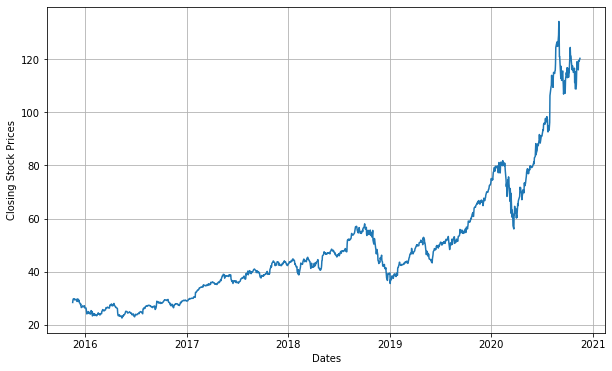

In [3]:
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Stock Prices')
plt.plot(df.Close)
plt.grid()
plt.show()

### Checking for the stationarity of the timeseries using Augmented Dicky Fuller test

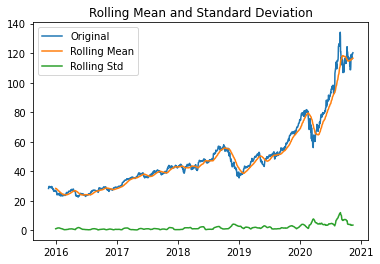

Results of dickey fuller test
Test Statistics            1.148592
p value                    0.995611
no. of lags               22.000000
no of observations      1236.000000
critical value (1%)       -3.435652
critical value (5%)       -2.863881
critical value (10%)      -2.568016
dtype: float64


In [4]:
def stationarity_test(test_df):
    roll_mean = test_df.rolling(30).mean()
    roll_std = test_df.rolling(30).std()
    plt.plot(test_df,label='Original')     #Plotting the statistics
    plt.plot(roll_mean, label='Rolling Mean')
    plt.plot(roll_std, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(test_df,autolag='AIC')  # Augmented Dicky fuller Test
    output = pd.Series(adft[0:4],index=['Test Statistics','p value','no. of lags','no of observations'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
stationarity_test(df)

From the above test we can conclude that the mean and std dev are not constant over time and hence the time series is not stationary.
To make the data stationary we seperate the trend and seasonal compotent of the data in the cell below.

### Seperating the seasonality and trend from the data

<Figure size 432x288 with 0 Axes>

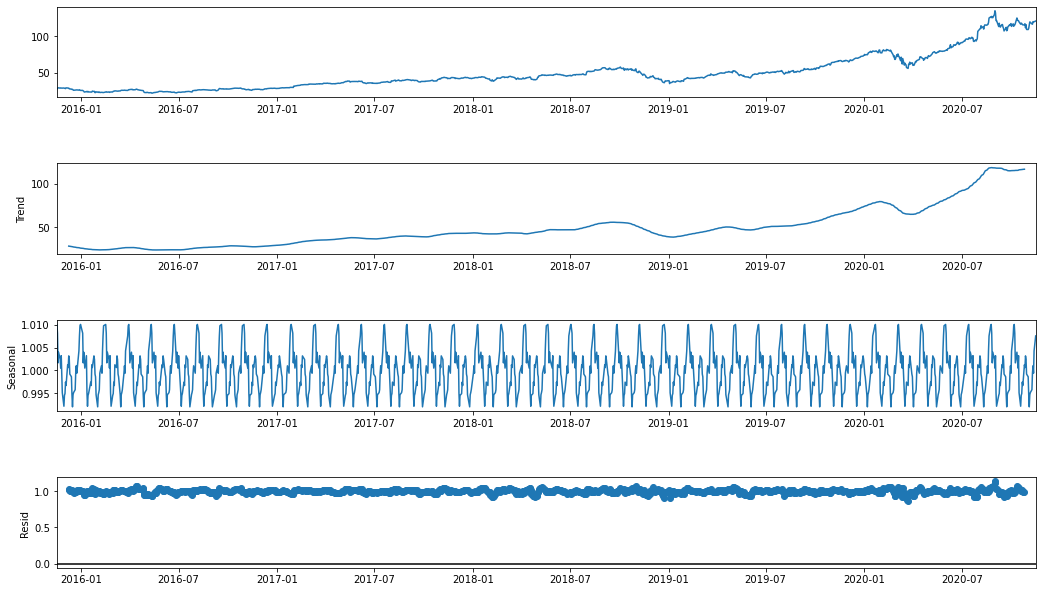

In [5]:
result = seasonal_decompose(df, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

### Making the data Stationary

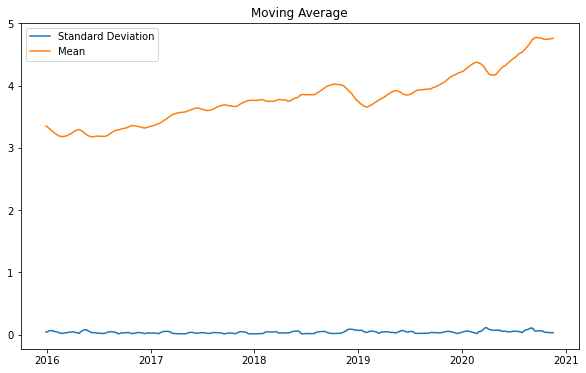

In [17]:
df_log = np.log(df)    # Taking the log of the data
moving_avg = df_log.rolling(30).mean()
std_dev = df_log.rolling(30).std()
plt.figure(figsize=(10,6))
plt.title('Moving Average')
plt.plot(std_dev, label = "Standard Deviation")
plt.plot(moving_avg, label = "Mean")
plt.legend(loc='best')
plt.show()

We can see that the mean and standard deviation is more constant over time comapred to the previous graph.

### Splitting the data 

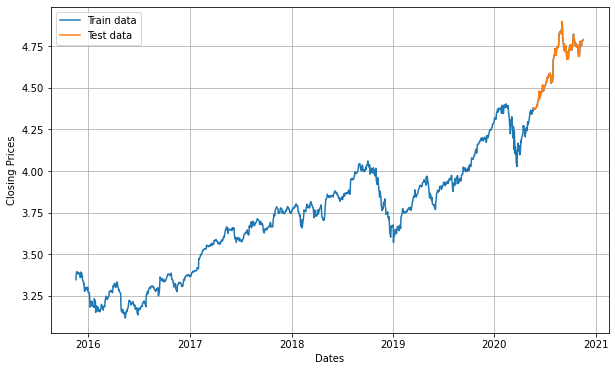

In [7]:
train_data = df_log[:int(len(df_log)*0.9)]
test_data =  df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, test='adf', max_p=3, max_q=3, m=1, d=None, seasonal=False, start_P=0, D=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5856.190, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5871.399, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5870.630, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5855.450, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5869.699, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5869.712, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5867.560, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5869.919, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.622 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1133
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2938.700
Date:                Wed, 18 Nov 2020   AIC                          -5871.399
Time:                       

#### We get the values for p = 1, d = 1, q = 0 from the above summary

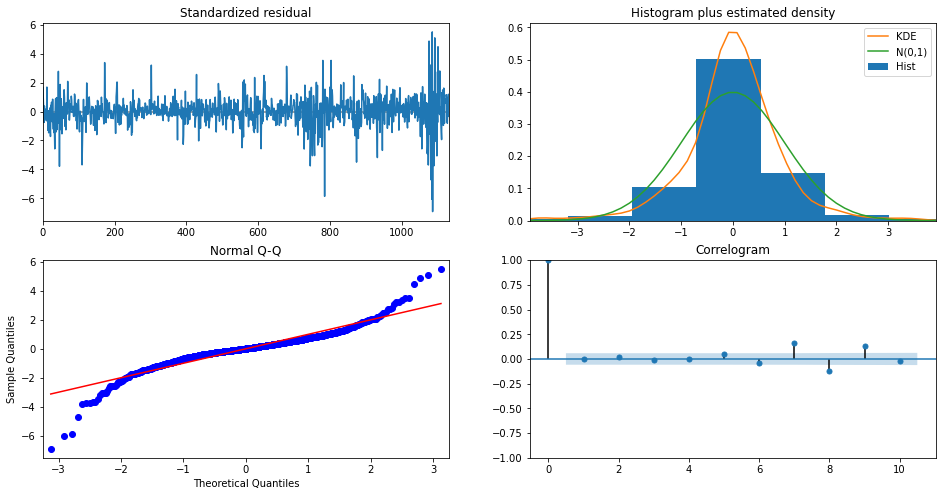

In [9]:
model_autoARIMA.plot_diagnostics(figsize=(16,8))
plt.show()

In [10]:
model = ARIMA(train_data, order=(1, 1, 0))  # Entring the values of p,d,q in the model.
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1132
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2938.700
Method:                       css-mle   S.D. of innovations              0.018
Date:                Wed, 18 Nov 2020   AIC                          -5871.400
Time:                        17:30:11   BIC                          -5856.305
Sample:                             1   HQIC                         -5865.697
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.000      1.869      0.062   -4.34e-05       0.002
ar.L1.D.Close    -0.1229      0.030     -4.164      0.000      -0.181      -0.065
                                    Root

C:\Users\parth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\parth\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


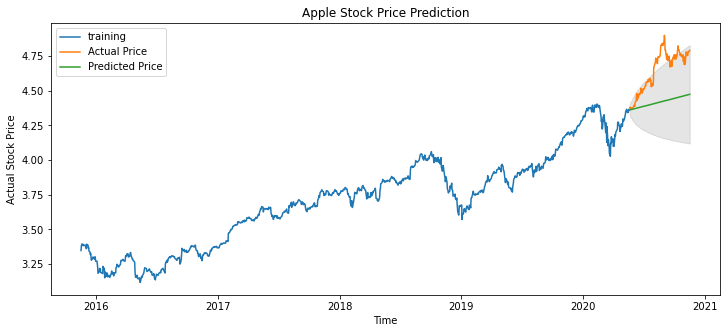

In [13]:
forec, se, conf = fitted.forecast(126, alpha=0.05)
forecast_series = pd.Series(forec, index=test_data.index)
l_series = pd.Series(conf[:, 0], index=test_data.index)
u_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5))
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Price')
plt.plot(forecast_series,label='Predicted Price')
plt.fill_between(l_series.index, l_series, u_series, color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='best')
plt.show()

In [15]:
test_data = np.array(test_data).reshape(126,1)
mape = np.mean(np.abs(forec - test_data)/np.abs(test_data))
print(f'MAPE: {mape}')

MAPE: 0.050342097643080376


#### From the MAPE value we can say that the model is 95% accurate.